In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import seaborn
import json
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_curve,average_precision_score
from sklearn.metrics import average_precision_score

## Table of Contents

[Problem definition](#cell1)

[Data Exploration](#cell2)

[Building a model to predict conversion rate](#cell3)

[Conclusion](#cell4)

<a id='cell1'></a>

### Problem definition

Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so.
The data revolution has a lot to do with the fact that now we are able to collect all sorts of data
about people who buy something on our site as well as people who don't. This gives us a
tremendous opportunity to understand what's working well (and potentially scale it even further)
and what's not working well (and fix it).

The goal of this challenge is to build a model that predicts conversion rate and, based on the
model, come up with ideas to improve re enue.

We have data about users who hit our site: whether they converted or not as well as some of
their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).
Your project is to:
Predict conversion rate
Come up with recommendations for the product team and the marketing team to
improve conversion rate




<a id='cell2'></a>

### Data Explortation

In [4]:
conversion_data = pd.read_csv('conversion_data.csv')
conversion_data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [9]:
conversion_data.groupby('country').describe()

age                                                      \
            count       mean       std   min   25%   50%   75%    max   
country                                                                 
China     76602.0  30.672972  8.283862  17.0  24.0  30.0  36.0   69.0   
Germany   13056.0  30.449985  8.289022  17.0  24.0  30.0  36.0  123.0   
UK        48450.0  30.451538  8.244991  17.0  24.0  30.0  36.0  111.0   
US       178092.0  30.566482  8.272128  17.0  24.0  30.0  36.0   79.0   

        converted            ...  new_user      total_pages_visited            \
            count      mean  ...       75%  max               count      mean   
country                      ...                                                
China     76602.0  0.001332  ...       1.0  1.0             76602.0  4.553523   
Germany   13056.0  0.062500  ...       1.0  1.0             13056.0  5.190717   
UK        48450.0  0.052632  ...       1.0  1.0             48450.0  5.082167   
US       178092.0  0.037801  ...       1.0  1.0            178092.0  4.930160   

                                             
              std  min  25%  50%  75%   max  
country                                      
China    2.804987  1.0  2.0  4.0  6.0  26.0  
Germany  3.762899  1.0  2.0  4.0  7.0  27.0  
UK       3.630763  1.0  2.0  4.0  7.0  27.0  
US       3.427085  1.0  2.0  4.0  7.0  29.0  

[4 rows x 32 columns]

In [65]:
conversion_data['age'].describe()

count    316200.000000
mean         30.569858
std           8.271802
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max         123.000000
Name: age, dtype: float64

(15, 65)

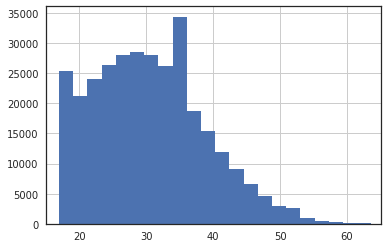

In [68]:
conversion_data['age'].hist(bins=50)
plt.xlim([15,65])

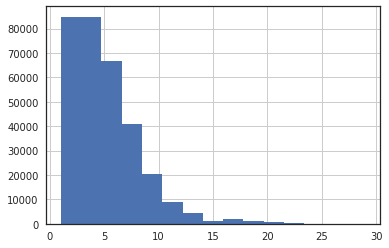

In [71]:
conversion_data['total_pages_visited'].hist(bins=15)

In [31]:
conversion_onehot = pd.get_dummies(conversion_data)
print(conversion_onehot.shape)
conversion_onehot.head()

(316200, 11)


,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


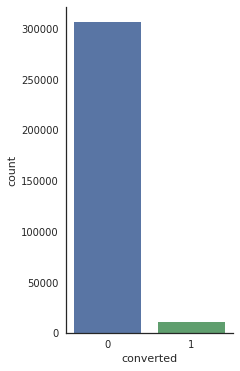

In [44]:
plt.figure(figsize=(3,6))
sns.set(style='white')
ax = sns.countplot(x='converted', data=conversion_onehot)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

<a id='cell3'></a>

### Model Building

In [46]:
cross_validation_df = conversion_onehot.sample(frac=0.7)
test_df = conversion_onehot[~conversion_onehot.index.isin(cross_validation_df.index)]
print(cross_validation_df.shape)
print(test_df.shape)

(221340, 11)
(94860, 11)


In [60]:

kf = KFold(n_splits=3)
for train_index, valid_index in kf.split(cross_validation_df):
    
    train_X = cross_validation_df.iloc[train_index,:]
    valid_X = cross_validation_df.iloc[valid_index,:]

    lgb_train = lgb.Dataset(train_X.drop(['converted'], axis=1), train_X.converted)

    lgb_eval = lgb.Dataset(valid_X.drop(['converted'], axis=1), valid_X.converted)

    # specify your configurations as a dict
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'binary_logloss','auc'},
        #'num_leaves': 8,
        'learning_rate': 0.1,
        'verbose': 50
    }
    print('Start training...')
    # train
    evals_result = {} 
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=50,
                    valid_sets=lgb_eval,
                    evals_result=evals_result,
                    early_stopping_rounds=1)

#     print('Save model...')
#     # save model to file
#     gbm.save_model('model.txt')


Start training...
[1]	valid_0's binary_logloss: 0.602389	valid_0's auc: 0.959254
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's binary_logloss: 0.528094	valid_0's auc: 0.959353
[3]	valid_0's binary_logloss: 0.46617	valid_0's auc: 0.959417
[4]	valid_0's binary_logloss: 0.413878	valid_0's auc: 0.968975
[5]	valid_0's binary_logloss: 0.36927	valid_0's auc: 0.969006
[6]	valid_0's binary_logloss: 0.330886	valid_0's auc: 0.969756
[7]	valid_0's binary_logloss: 0.297644	valid_0's auc: 0.970003
[8]	valid_0's binary_logloss: 0.268711	valid_0's auc: 0.970042
[9]	valid_0's binary_logloss: 0.243401	valid_0's auc: 0.970097
[10]	valid_0's binary_logloss: 0.221195	valid_0's auc: 0.970104
[11]	valid_0's binary_logloss: 0.201614	valid_0's auc: 0.975434
[12]	valid_0's binary_logloss: 0.184319	valid_0's auc: 0.976834
[13]	valid_0's binary_logloss: 0.169007	valid_0's auc: 0.977133
[14]	valid_0's binary_logloss: 0.155437	valid_0's auc: 0.977205
[15]	valid_0's binary_logloss: 0.143

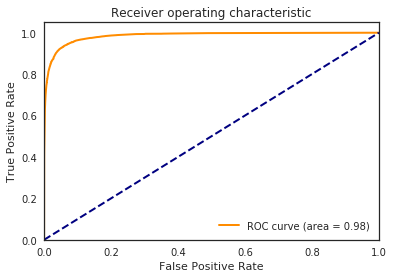

In [56]:
y_pred = gbm.predict(test_df.drop('converted',axis=1), num_iteration=gbm.best_iteration)

fpr, tpr, thresholds = roc_curve(test_df.converted, y_pred)
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right",frameon=False)

plt.show()

Average precision-recall score: 0.84
Baseline precision is: 0.0323634830276


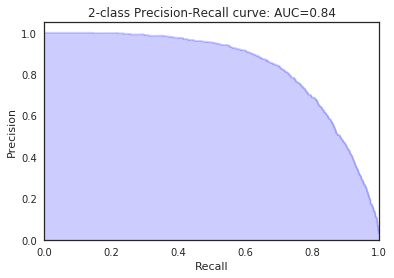

In [57]:
average_precision = average_precision_score(test_df.converted, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

print('Baseline precision is:',test_df['converted'].mean())
precision, recall, _ = precision_recall_curve(test_df.converted, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))


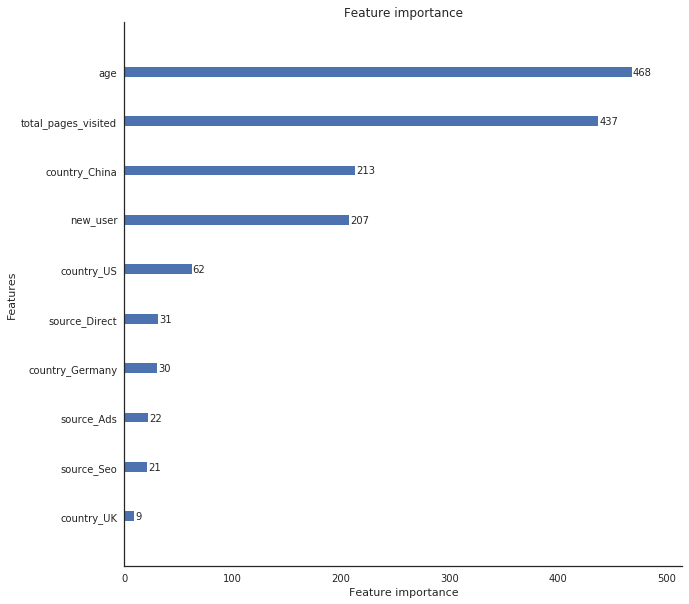

In [58]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
lgb.plot_importance(gbm,ax=ax,importance_type='split')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

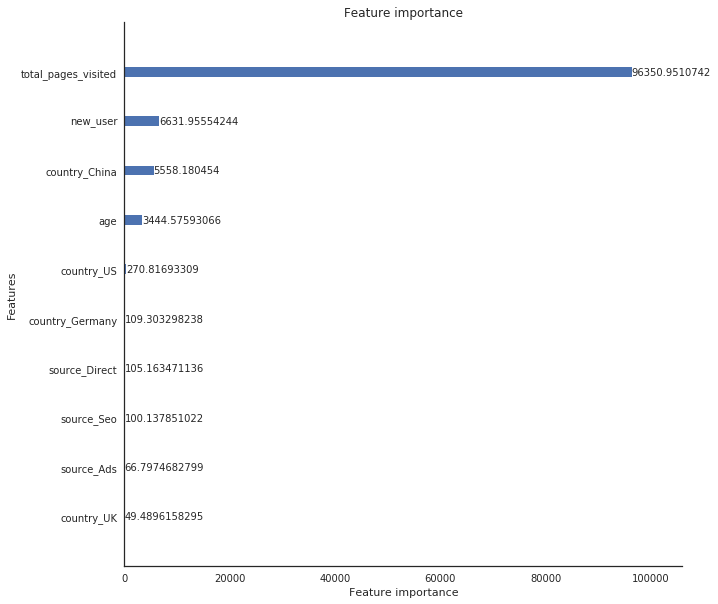

In [59]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
lgb.plot_importance(gbm,ax=ax,importance_type='gain')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

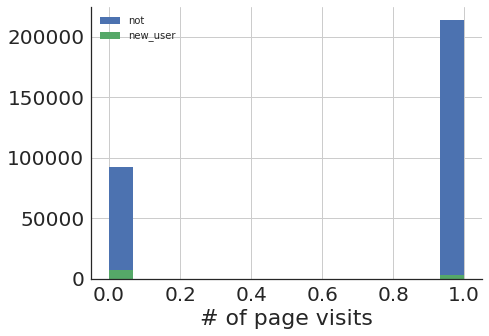

In [78]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
conversion_data.loc[conversion_data.converted==0,'new_user'].hist(bins=15,ax=ax,label='not')
conversion_data.loc[conversion_data.converted==1,'new_user'].hist(bins=15,ax=ax,label='new_user')
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
plt.xlabel("# of page visits",**axis_font)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

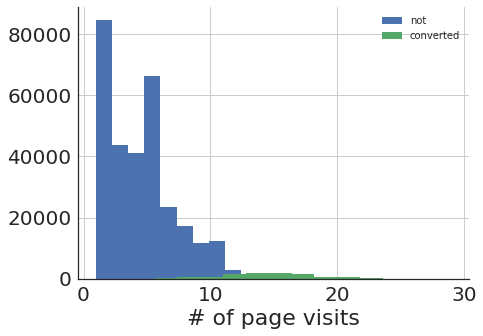

In [79]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
conversion_data.loc[conversion_data.converted==0,'total_pages_visited'].hist(bins=15,ax=ax,label='not')
conversion_data.loc[conversion_data.converted==1,'total_pages_visited'].hist(bins=15,ax=ax,label='converted')
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
plt.xlabel("# of page visits",**axis_font)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

<a id='cell4'></a>

# Conclusion: 
Biggest determinant of conversion rate is number of page visits. My suggestion for the company would be to increase the original content in their website or make it more interesting in order to make sure that the users spend more time on the website